In [28]:
## Import libraries ##
import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd

In [75]:
## Define basic functions ##

#generate points that aren't too close to each other
def generate_points(minX, maxX, N, min_distance = 0.05, dim = 1):
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(-5, 5, size=(2,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.linalg.norm(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)

# This is the true unknown function we are trying to approximate
f = lambda x,y: np.sin(0.5*np.sqrt(x**2 + y**2))


#squared expo kernel
def kernel(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo


# Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
def posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma, dim = 2):
    '''
    Args:
        X: Training features (N x dim)
        y: Training targets (N x 1)
        hyperparameters
        
    Returns:
        Xtest: new input locations used (n x dim)
        mu: posterior mean vector (n x 1)
        std: posterior std (n x 1)
    '''
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    #K.shape = (N x N)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))
    #L.shape = (N x N)

    ## 3) Predictive mean at test points
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)
    
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    #v.shape = (N x n)
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    #b.shape = (N x 1)
    mu = np.dot(v.T, b) #f_* = v^Tb
    #mu.shape = (n x 1)

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q) 
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    #sigma.shape = (n x n)
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))
    
    return g, Xtest, mu, std


#Given test point x (Xtest_val), what is y?
def conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    #K.shape = (N x N)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))
    #L.shape = (N x N)

    ## 3) Predictive mean at test points
    Xtest = np.asarray(Xtest_val)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))

    return Xtest_val, mu, std

    
def plot_2D(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    Only use when X is 2D
    '''
    g, Xtest, mu, std = posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma, dim = 2)

    ##Render plots
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Plot predictive mean
    gx1, gx2 = g[0], g[1]

    #Render plots
    surf = ax.plot_surface(gx1, gx2, mu.reshape(gx1.shape), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha = 0.3)

    #Plot training data
    ax.scatter(X[:,0], X[:,1], y, c = y, marker = 'o', cmap=cm.coolwarm)
    
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

## Given

Text(0.5, 0.5, 'X2')

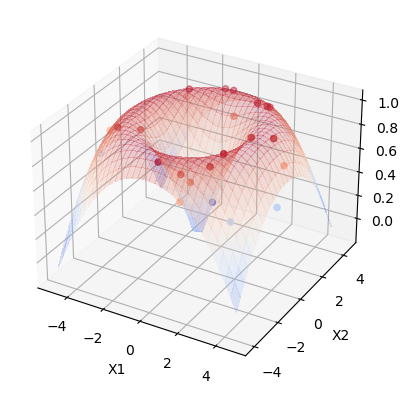

In [81]:
#This is our dataset
N = 26 #must be even
D = 2 #dimension
X = generate_points(-4, 4, N/2, min_distance = 3, dim = D)
X1 = X[:,0]
X2 = X[:,1]
y = (f(X1,X2) + np.random.normal(0,0,N)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Function we'd like to estimate --> our goal
rx1, rx2 = np.arange(np.min(X1), np.max(X1), 0.3), np.arange(np.min(X2), np.max(X2), 0.3)
gx1, gx2 = np.meshgrid(rx1, rx2)
x = np.c_[gx1.ravel(), gx2.ravel()]

#Render plots
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(gx1, gx2, f(gx1,gx2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.2)
ax.scatter(X1,X2,y, c = y, marker = 'o', cmap=cm.coolwarm)

ax.set_xlabel('X1')
ax.set_ylabel('X2')

**Feature Scaling**

In [82]:
#Normalize feature:
X = (X - np.min(X))/(np.max(X) - np.min(X)) #X in [0,1]
X1 = X[:,0]
X2 = X[:,1]

#Normalize target:
#y = (y - min(y))/(max(y)-min(y))

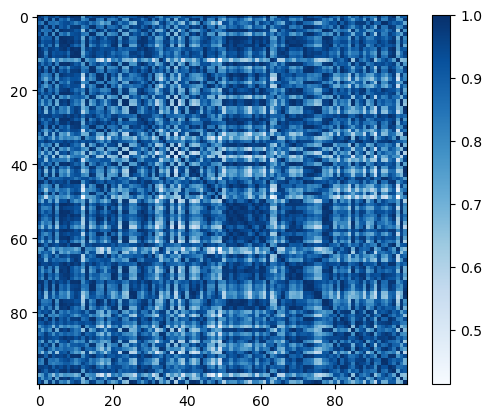

In [83]:
#Plot of kernel
x = np.random.uniform(-4, 4, size=(100,2))
x = (x - np.min(x))/(np.max(x) - np.min(x)) #X in [0,1]
K = kernel(x, x, 1, 1)

plt.imshow(K, cmap = 'Blues', interpolation = 'nearest')
plt.colorbar()
plt.show()

Text(0.5, 0.5, 'X2')

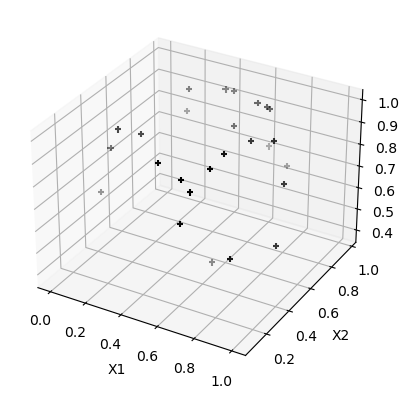

In [84]:
#Render plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(X1,X2,y, marker = '+', color = "black")
ax.set_xlabel('X1')
ax.set_ylabel('X2')

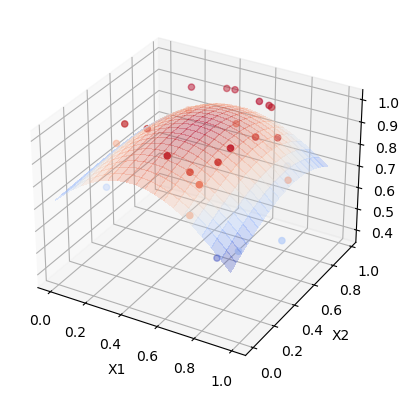

In [85]:
#Plot of GP fit before parameter optimization
plot_2D(X, y, 0.1, 1, 1)

**Choosing initial parameters**

In [86]:
#Initial guesses#
init_sigma_n = 0.0001 #np.std(y) # guess for observation noise
init_len_scale = 0.5
init_sigma_f = (np.abs(np.min(y)) + np.abs(np.max(y)))/2 #this is the semi-range

init_par = [init_sigma_n, init_len_scale, init_sigma_f]
init_par #these are the optimum parameters

[0.0001, 0.5, 0.6929290734142212]

### Marginal likelihood

In [87]:
# Negative Marginal log-likelihood of the GP we would like to optimize
def gp_loss_fn(par,X,y): #input observations (X,y) and initial parameters (guess)
    sigma_n, l, sigma = par #noise std, lengthscale l, and signal std
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #negative marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return mll #this is our objective function

#### Optimization

In [91]:
# Nelder-Mead
opt_par = minimize(gp_loss_fn, init_par, args=(X,y), method="Nelder-Mead", options = {'disp':True})
sigma_n, l, sigma = opt_par.x[0], opt_par.x[1], opt_par.x[2]
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )

Optimization terminated successfully.
         Current function value: -20.508779
         Iterations: 129
         Function evaluations: 234
sigma_n = -0.000001, l = 0.250641, sigma_f = 0.536842


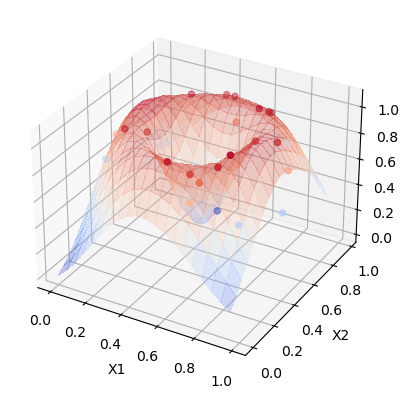

In [92]:
plot_2D(X, y, sigma_n, l, sigma)

Sources used:
- http://krasserm.github.io/2018/03/19/gaussian-processes/?utm_source=pocket_saves